##  Time-lagged conversion rates and cure models

Suppose in our population we have a subpopulation that will never experience the event of interest. Or, for some subjects the event will occur so far in the future that it's essentially at time infinity. The survival function should not asymptically approach zero, but _some positive value_. Models that describe this are sometimes called cure models (i.e. the subject is "cured" of death and hence no longer susceptible) or time-lagged conversion models. 

There's a serious fault in using parametric models for these types of problems that non-parametric models don't have. The most common parametric models like Weibull, Log-Normal, etc. all have strictly increasing cumulative hazard functions, which means the corresponding survival function will always converge to 0. 

Let's look at an example of this problem. Below I generated some data that has individuals who _will not experience the event_, not matter how long we wait.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from matplotlib import pyplot as plt
import autograd.numpy as np
from autograd.scipy.special import expit, logit
import pandas as pd
plt.style.use('bmh')


In [2]:
N = 200
U = np.random.rand(N)
T = -(logit(-np.log(U) / 0.5) - np.random.exponential(2, N) - 6.00) / 0.50

E = ~np.isnan(T)
T[np.isnan(T)] = 50

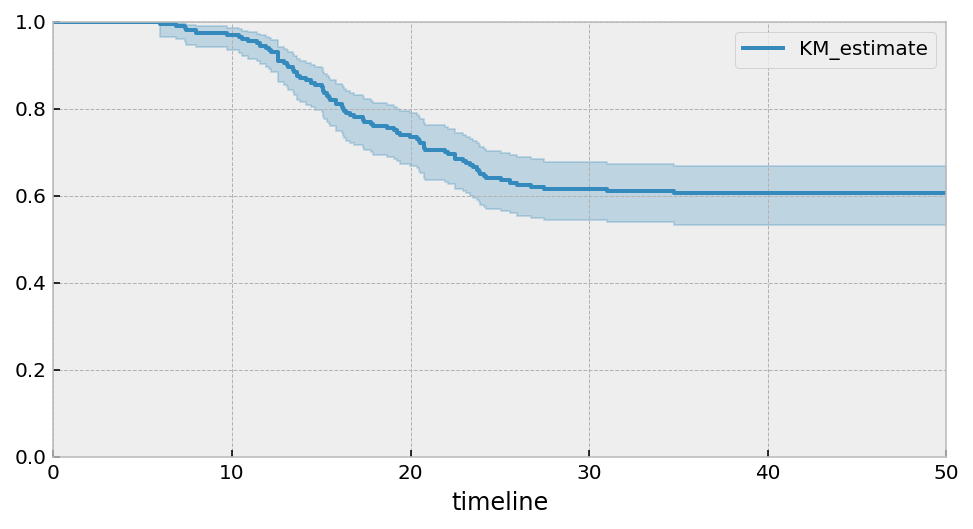

In [3]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter().fit(T, E)
kmf.plot(figsize=(8,4))
plt.ylim(0, 1);

It should be clear that there is an asymptote at around 0.6. The non-parametric model will always show this. If this is true, then the cumulative hazard function should have a horizontal asymptote as well. Let's use the Nelson-Aalen model to see this. 

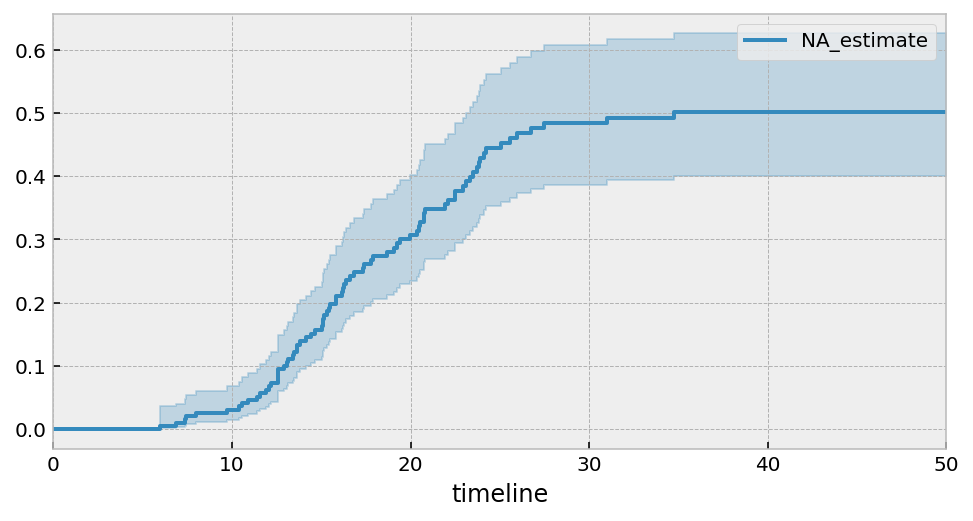

In [4]:
from lifelines import NelsonAalenFitter

naf = NelsonAalenFitter().fit(T, E)
naf.plot(figsize=(8,4))

_However_, when we try a parametric model, we will see that it won't extrapolate very well. Let's use the flexible two parameter LogLogisticFitter model. 

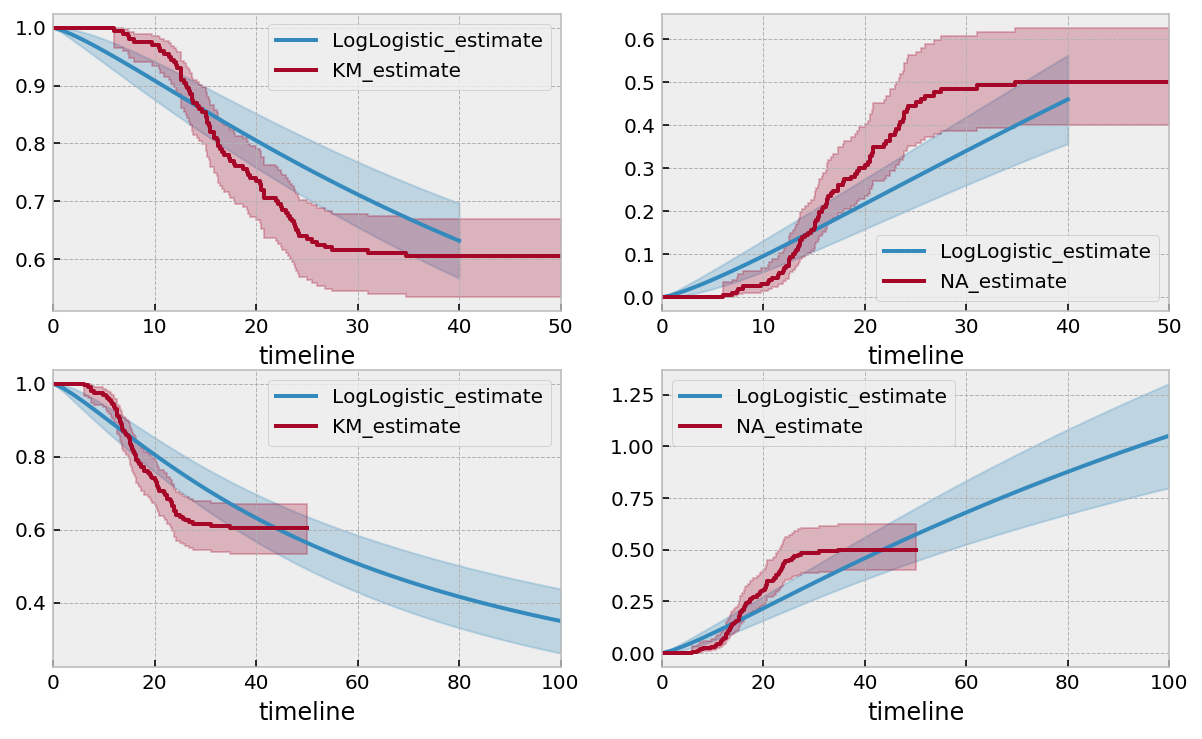

In [5]:
from lifelines import LogLogisticFitter

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))

t = np.linspace(0, 40)
llf = LogLogisticFitter().fit(T, E, timeline=t)


llf.plot_survival_function(ax=ax[0][0])
kmf.plot(ax=ax[0][0])

llf.plot_cumulative_hazard(ax=ax[0][1])
naf.plot(ax=ax[0][1])

t = np.linspace(0, 100)
llf = LogLogisticFitter().fit(T, E, timeline=t)

llf.plot_survival_function(ax=ax[1][0])
kmf.plot(ax=ax[1][0])

llf.plot_cumulative_hazard(ax=ax[1][1])
naf.plot(ax=ax[1][1])

The LogLogistic model does a quite terrible job of capturing the not only the asymptotes, but also the intermediate values as well. If we extended the survival function out further, we would see that it eventually nears 0. 

### Custom parametric models to handle asymptotes

Focusing on modeling the cumulative hazard function, what we would like is a function that increases up to a limit and then tapers off to an asymptote. We can think long and hard about these (I did), but there's a family of functions that have this property that we are very familiar with: cumulative distribution functions! By their nature, they will asympotically approach 1. And, they are readily available in the SciPy and autograd libraries. So our new model of the cumulative hazard function is:

$$H(t; c, \theta) = c F(t; \theta)$$

where $c$ is the (unknown) horizontal asymptote, and $\theta$ is a vector of (unknown) parameters for the CDF, $F$. 

We can create a custom cumulative hazard model using `ParametricUnivariateFitter` (for a tutorial on how to create custom models, see [this here](Piecewise Exponential Models and Creating Custom Models.ipynb)). Let's choose the Normal CDF for our model. 

Remember we **must** use the imports from `autograd` for this, i.e. `from autograd.scipy.stats import norm`.

In [6]:
from autograd.scipy.stats import norm
from lifelines.fitters import ParametricUnivariateFitter


class UpperAsymptoteFitter(ParametricUnivariateFitter):

    _fitted_parameter_names = ["c_", "mu_", "sigma_"]

    _bounds = ((0, None), (None, None), (0, None))

    def _cumulative_hazard(self, params, times):
        c, mu, sigma = params
        return c * norm.cdf((times - mu) / sigma, loc=0, scale=1)

<lifelines.UpperAsymptoteFitter: fitted with 200 observations, 121 censored>
number of subjects = 200
  number of events = 79
    log-likelihood = -383.507
        hypothesis = c_ != 1, mu_ != 0, sigma_ != 1

---
         coef  se(coef)  lower 0.95  upper 0.95       p  -log2(p)
c_      0.505     0.057       0.392       0.617 <0.0005    57.343
mu_    18.040     0.650      16.765      19.315 <0.0005   560.110
sigma_  5.711     0.456       4.818       6.604 <0.0005    80.811


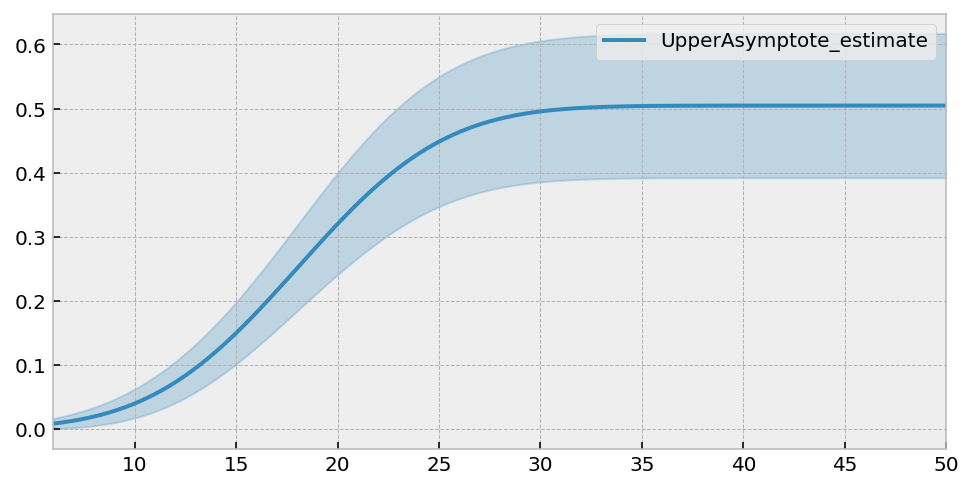

In [7]:
uaf = UpperAsymptoteFitter().fit(T, E)
uaf.print_summary(3)
uaf.plot(figsize=(8,4))

We get a lovely asympotical cumulative hazard. The summary table suggests that the best value of $c$ is 0.586. This can be translated into the survival function asymptote by $\exp(-0.586) \approx 0.56$.

Let's compare this fit to the non-parametric models. 

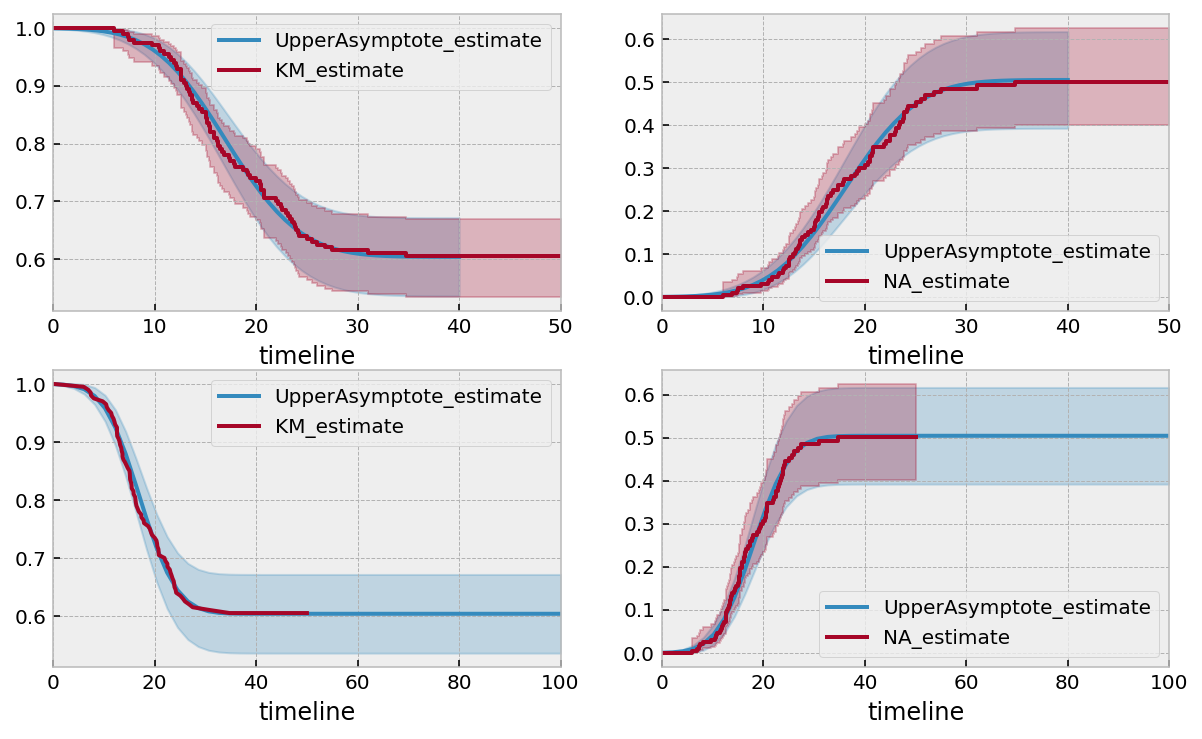

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))

t = np.linspace(0, 40)
uaf = UpperAsymptoteFitter().fit(T, E, timeline=t)

uaf.plot_survival_function(ax=ax[0][0])
kmf.plot(ax=ax[0][0])

uaf.plot_cumulative_hazard(ax=ax[0][1])
naf.plot(ax=ax[0][1])

t = np.linspace(0, 100)
uaf = UpperAsymptoteFitter().fit(T, E, timeline=t)
uaf.plot_survival_function(ax=ax[1][0])
kmf.survival_function_.plot(ax=ax[1][0])

uaf.plot_cumulative_hazard(ax=ax[1][1])
naf.plot(ax=ax[1][1])

I wasn't expect this good of a fit. But there it is. This was some artificial data, but let's try this technique on some real life data. 

<lifelines.UpperAsymptoteFitter: fitted with 42 observations, 12 censored>
number of subjects = 42
  number of events = 30
    log-likelihood = -118.60
        hypothesis = c_ != 1, mu_ != 0, sigma_ != 1

---
        coef  se(coef)  lower 0.95  upper 0.95      p  -log2(p)
c_      1.63      0.36        0.94        2.33   0.07      3.75
mu_    13.44      1.73       10.06       16.82 <0.005     47.07
sigma_  7.03      1.07        4.94        9.12 <0.005     25.91
---
Estimated lower bound: 0.20 (0.10, 0.39)


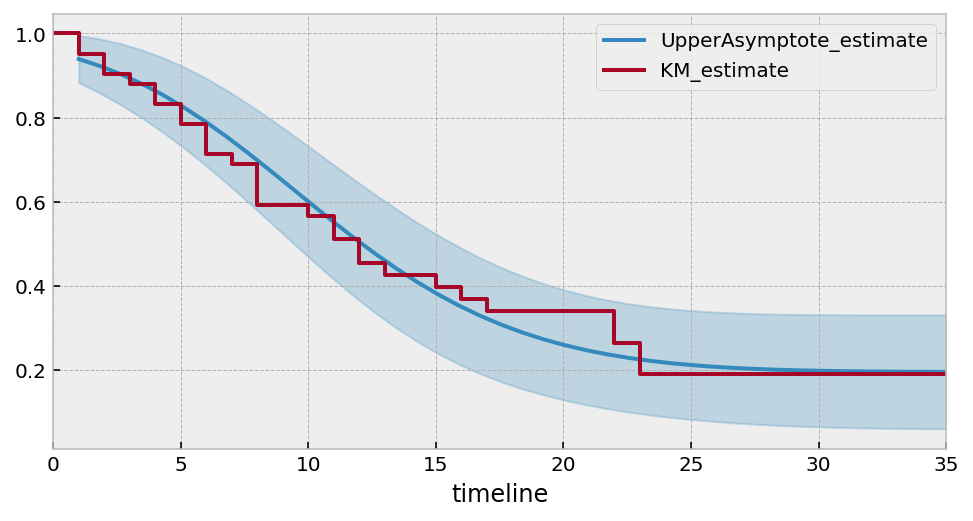

In [9]:
from lifelines.datasets import load_leukemia, load_kidney_transplant

T, E = load_leukemia()['t'], load_leukemia()['status']
uaf.fit(T, E)
ax = uaf.plot_survival_function(figsize=(8,4))
uaf.print_summary()

kmf.fit(T, E).plot(ax=ax, ci_show=False)
print("---")
print("Estimated lower bound: {:.2f} ({:.2f}, {:.2f})".format(
        np.exp(-uaf.summary.loc['c_', 'coef']),
        np.exp(-uaf.summary.loc['c_', 'upper 0.95']),
        np.exp(-uaf.summary.loc['c_', 'lower 0.95']),
    )
)

So we might expect that about 20% will not have the even in this population (but make note of the large CI bounds too!)

<lifelines.UpperAsymptoteFitter: fitted with 863 observations, 723 censored>
number of subjects = 863
  number of events = 140
    log-likelihood = -1458.88
        hypothesis = c_ != 1, mu_ != 0, sigma_ != 1

---
          coef  se(coef)  lower 0.95  upper 0.95      p  -log2(p)
c_        0.29      0.03        0.24        0.35 <0.005    433.79
mu_    1139.65    101.52      940.68     1338.62 <0.005     94.73
sigma_  872.25     66.23      742.43     1002.06 <0.005    128.87
---
Estimated lower bound: 0.75 (0.70, 0.79)


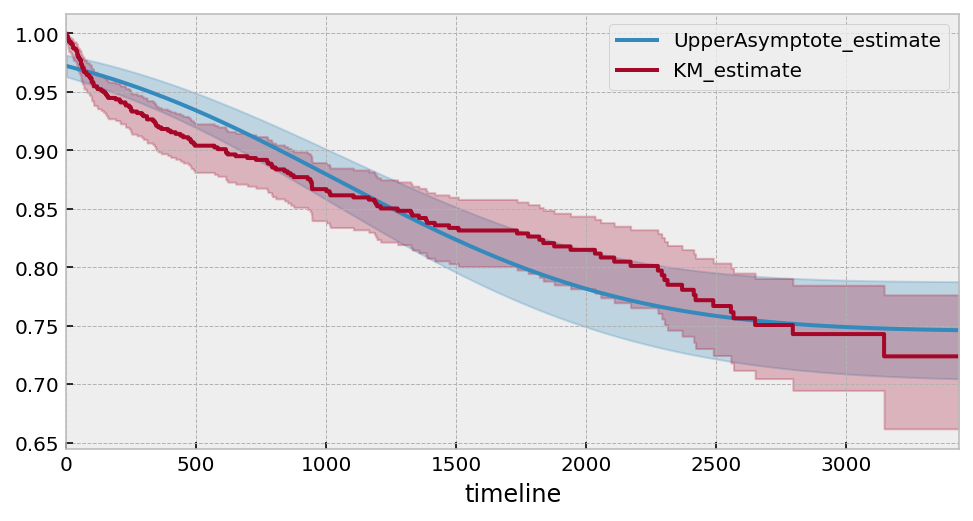

In [10]:
# Another, less obvious, dataset. 

T, E = load_kidney_transplant()['time'], load_kidney_transplant()['death']
uaf.fit(T, E)
ax = uaf.plot_survival_function(figsize=(8,4))
uaf.print_summary()

kmf.fit(T, E).plot(ax=ax)
print("---")
print("Estimated lower bound: {:.2f} ({:.2f}, {:.2f})".format(
        np.exp(-uaf.summary.loc['c_', 'coef']),
        np.exp(-uaf.summary.loc['c_', 'upper 0.95']),
        np.exp(-uaf.summary.loc['c_', 'lower 0.95']),
    )
)

#### Using alternative functional forms

An even simplier model might look like $c \left(1 - \frac{1}{\lambda t + 1}\right)$, however this model cannot handle any "inflection points" like our artificial dataset has above. However, it works well for this Lung dataset. 

With all parametric models, one important feature is the ability to extrapolate to unforseen times. 

In [11]:
from autograd.scipy.stats import norm
from lifelines.fitters import ParametricUnivariateFitter

class SimpleUpperAsymptoteFitter(ParametricUnivariateFitter):

    _fitted_parameter_names = ["c_", "lambda_"]

    _bounds = ((0, None), (0, None))

    def _cumulative_hazard(self, params, times):
        c, lambda_ = params
        return c * (1 -  1 /(lambda_ * times + 1))

<lifelines.SimpleUpperAsymptoteFitter: fitted with 863 observations, 723 censored>
number of subjects = 863
  number of events = 140
    log-likelihood = -1392.1610
        hypothesis = c_ != 1, lambda_ != 1

---
          coef  se(coef)  lower 0.95  upper 0.95      p  -log2(p)
c_      0.4252    0.0717      0.2847      0.5658 <5e-05   49.6859
lambda_ 0.0006    0.0002      0.0003      0.0009 <5e-05       inf
---
Estimated lower bound: 0.65 (0.57, 0.75)


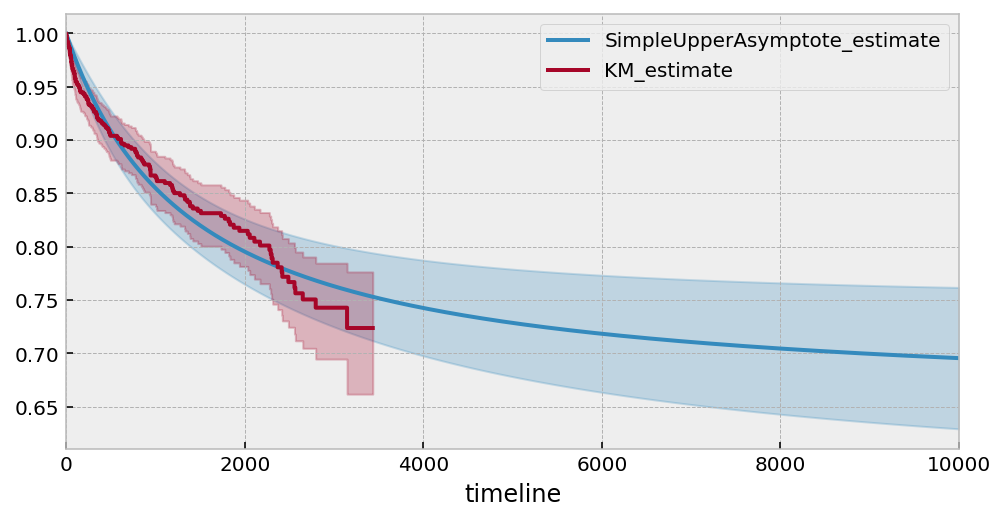

In [12]:
# Another, less obvious, dataset. 

saf = SimpleUpperAsymptoteFitter().fit(T, E, timeline=np.arange(1, 10000))
ax = saf.plot_survival_function(figsize=(8,4))
saf.print_summary(4)

kmf.fit(T, E).plot(ax=ax)
print("---")
print("Estimated lower bound: {:.2f} ({:.2f}, {:.2f})".format(
        np.exp(-saf.summary.loc['c_', 'coef']),
        np.exp(-saf.summary.loc['c_', 'upper 0.95']),
        np.exp(-saf.summary.loc['c_', 'lower 0.95']),
    )
)

### Probabilistic cure models

The models above are good at fitting to the data, but they offer less common interpretation of survival models. It would be nice to be able to use common survival models _and_ have some "cure" component. Let's suppose that for individuals that will experience the event of interest, their survival distrubtion is a Weibull, denoted $S_W(t)$. For a random selected individual in the population, thier survival curve, $S(t)$, is:

$$ 
\begin{align*}
S(t) = P(T > t) &= P(\text{cured}) P(T > t\;|\;\text{cured}) +  P(\text{not cured}) P(T > t\;|\;\text{not cured})  \\
      &= p + (1-p) S_W(t)
\end{align*}
$$

Even though it's in an unconvential form, we can still determine the cumulative hazard (which is the negative logarithm of the survival function):

$$ H(t) =  -\log{\left(p + (1-p) S_W(t)\right)} $$

In [13]:
from autograd import numpy as np
from lifelines.fitters import ParametricUnivariateFitter

class CureFitter(ParametricUnivariateFitter):

    _fitted_parameter_names = ["p_", "lambda_", "rho_"]

    _bounds = ((0, 1), (0, None), (0, None))

    def _cumulative_hazard(self, params, T):
        p, lambda_, rho_ = params
        sf = np.exp(-(T / lambda_) ** rho_)
        return -np.log(p + (1-p) * sf)

<lifelines.CureFitter: fitted with 863 observations, 723 censored>
number of subjects = 863
  number of events = 140
    log-likelihood = -1385.1617
        hypothesis = p_ != 0.5, lambda_ != 1, rho_ != 1

---
              coef   se(coef)  lower 0.95  upper 0.95      p  -log2(p)
p_          0.1008     1.3027     -2.4524      2.6540 0.7593    0.3973
lambda_ 17387.3611 48787.7896 -78234.9494 113009.6717 0.7216    0.4708
rho_        0.6381     0.0790      0.4833      0.7930 <5e-05   17.7075
---
Estimated lower bound: 0.10 (2.65, -2.45)


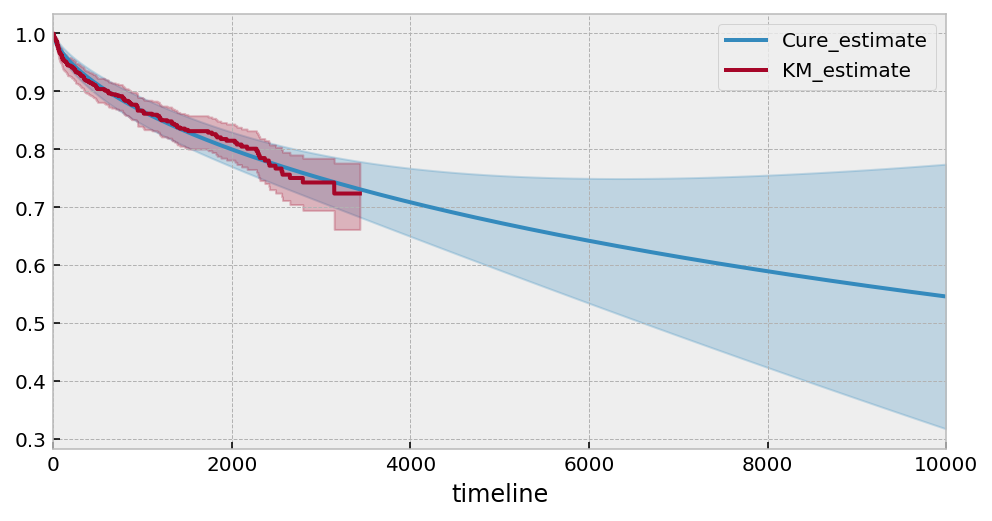

In [14]:
cure_model = CureFitter().fit(T, E, timeline=np.arange(1, 10000))
ax = cure_model.plot_survival_function(figsize=(8,4))
cure_model.print_summary(4)

kmf.fit(T, E).plot(ax=ax)
print("---")
print("Estimated lower bound: {:.2f} ({:.2f}, {:.2f})".format(
        cure_model.summary.loc['p_', 'coef'],
        cure_model.summary.loc['p_', 'upper 0.95'],
        cure_model.summary.loc['p_', 'lower 0.95'],
    )
)

Under this model, it suggests that only ~10% of subjects are ever cured (however, there is a lot of variance in the estimate of the $p$ parameter). 